In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_ollama import ChatOllama
from typing import Annotated
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

In [2]:
llm = ChatOllama(
    model=os.getenv("ollama_model"),
    reasoning=True,
)

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [4]:
graph_builder = StateGraph(State)

In [5]:
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


In [6]:
tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

In [7]:
def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

In [8]:
graph_builder.add_node("chatbot", chatbot)

In [9]:
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [10]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

In [11]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")

In [12]:
memory = InMemorySaver()

graph = graph_builder.compile(checkpointer=memory)

In [13]:
from IPython.display import Image, display

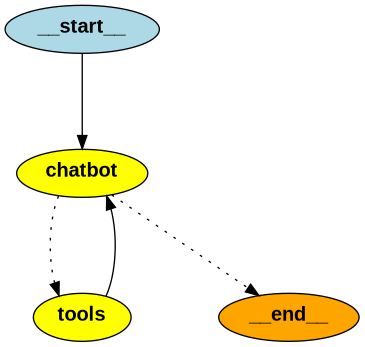

In [14]:
g = graph.get_graph()
png = g.draw_png()     # pygraphviz + graphviz 필요
display(Image(png))

In [15]:
config = {"configurable": {"thread_id": "1"}}

In [16]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (8e6314ca-4339-4f67-956f-8059e44b62bd)
 Call ID: 8e6314ca-4339-4f67-956f-8059e44b62bd
  Args:
    query: I need some expert guidance for building an AI agent.


In [17]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [18]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (8e6314ca-4339-4f67-956f-8059e44b62bd)
 Call ID: 8e6314ca-4339-4f67-956f-8059e44b62bd
  Args:
    query: I need some expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

Absolutely! I’ve reached out to the experts and they’re on board to help you build a powerful AI agent. In the meantime, here are a few key pointers and resources to get you started:

| Topic | What to Focus On | Quick Resources |
|-------|------------------|-----------------|
| **Agent Architecture** | Decide between a single‑loop (self‑contained) agent or a multi‑step, modu